# Machine learning for dimension reduction

## Principal component Analysis (PCA)

In [1]:
# libraries required
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Principal component Analysis (PCA) is a tool to investigate multi dimensional data. 

This method leads to ** project the initial raw data on orthogonal factorial plans**, which maximize the variance of the projected data.
 
This method is frequently used to 

1. represent the data in low dimension 
2. investigate the distribution of multi dimensional data
3. discover features or clusters in the data.

In [2]:
# data size (100, 120) => 100 signals sampled over 120 points
tab = pd.read_csv("sigref.csv",header=None); 
tab=np.array(tab); n=len(tab)
tab.shape

(100, 120)

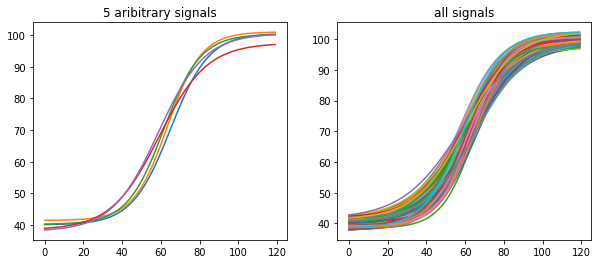

In [3]:
# pick up 5 samples randomly from dataset
rand_pick = tab[np.random.choice(tab.shape[0], 5, replace=False), :]

# visualize the set of temporal signals using a different color for each signal
figure = plt.figure(figsize=(10,4))
ax = plt.subplot(1,2,1); 
for i in range(rand_pick.shape[0]):
    plt.plot(rand_pick[i,:])
ax.set_title('5 aribitrary signals')

ax = plt.subplot(1,2,2)
for i in range(tab.shape[0]):
    plt.plot(tab[i,:])
ax.set_title('all signals')
plt.show()

In [4]:
# centerlize the original data
scaler = StandardScaler(with_std=False); scaler.fit(tab)
data_centered = scaler.transform(tab)

# PCA on functional data
pca = PCA(); pca.fit(data_centered) # n_compoments = min(n,p) = 100

# accumulative variance
cum_explained_var = []
for i in range(len(pca.explained_variance_ratio_)):
    if i == 0:
        cum_explained_var.append(pca.explained_variance_ratio_[i])
    else:
        cum_explained_var.append(pca.explained_variance_ratio_[i] + 

                                 cum_explained_var[i-1])
# print the first 10 of acum variance
cum_explained_var[:10]

[0.6183699919724701,
 0.8999180105405882,
 0.9744989703047282,
 0.9983773156235791,
 0.9997210241224289,
 0.9999896133350498,
 0.9999985707433724,
 0.9999998964851055,
 0.9999999272325635,
 0.9999999382700729]

In [5]:
# eigen vector has the same length as data (120)
pca.components_.shape

(100, 120)

In [6]:
# univariate matrix for U
pca.components_ @ pca.components_.T

array([[ 1.00000000e+00, -1.13279827e-16, -1.05234674e-16, ...,
        -6.93889390e-18,  2.42861287e-17,  2.12503626e-17],
       [-1.13279827e-16,  1.00000000e+00,  5.47558371e-17, ...,
        -7.63278329e-17, -4.16333634e-17,  6.93889390e-18],
       [-1.05234674e-16,  5.47558371e-17,  1.00000000e+00, ...,
         8.32667268e-17,  2.77555756e-17, -1.52655666e-16],
       ...,
       [-6.93889390e-18, -7.63278329e-17,  8.32667268e-17, ...,
         1.00000000e+00, -2.53042136e-16,  7.11768931e-17],
       [ 2.42861287e-17, -4.16333634e-17,  2.77555756e-17, ...,
        -2.53042136e-16,  1.00000000e+00,  1.38440010e-17],
       [ 2.12503626e-17,  6.93889390e-18, -1.52655666e-16, ...,
         7.11768931e-17,  1.38440010e-17,  1.00000000e+00]])

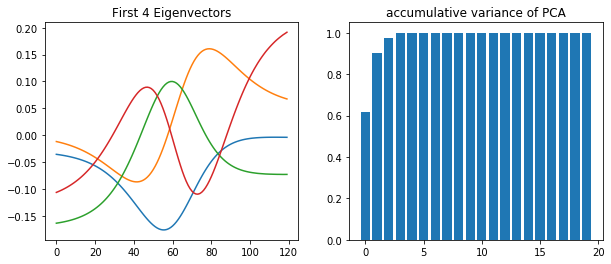

In [7]:
k = 4

figure = plt.figure(figsize=(10,4))
ax = plt.subplot(1,2,1); 
for i in range(k):
    plt.plot(pca.components_[i,:])
ax.set_title('First 4 Eigenvectors')

ax = plt.subplot(1,2,2)
plt.bar(height=cum_explained_var[:20],x = np.array(range(20)))
ax.set_title('accumulative variance of PCA')
plt.show()

## Signal compression

In [8]:
from sklearn.metrics import mean_squared_error

def reconstruct_kcomp(data=tab, components=pca.components_, target=tab[5,:], k=4):
    # standarization of the targeting data (**subtraction by components)
    target_adjust = target - data.mean(axis=0)

    # projection on the first k eigen vector
    selectVec = np.matrix(components[:k])   ### dim: (k,120)
    finalData = target_adjust @ selectVec.T ### dim: (k,120)*(120,1) -> (k,1)

    # reconstruction with the first k eigenvecs
    reconData = (finalData @ selectVec) + data.mean(axis=0).reshape(1,len(target)) ### dim: (1,k) * (k,120) -> (1,120)

    # compute the quadratic errors between each initial signal and its reconstruction
    error = mean_squared_error(target, reconData.T)

    return (finalData, reconData, error)

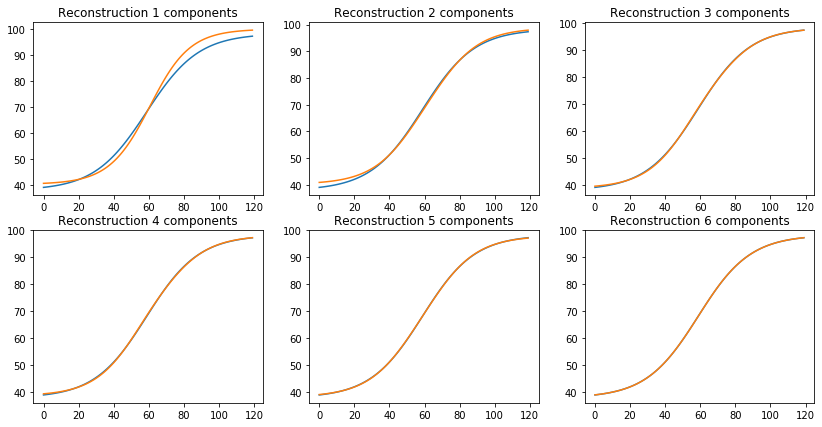

In [9]:
target = tab[5,:]; errors = []

figure = plt.figure(figsize=(14,7))
for i in range(6):
    _, recon, error = reconstruct_kcomp(target=target, k=i+1)
    errors.append(error)

    ax = plt.subplot(2,3,i+1); plt.plot(target); plt.plot(recon.T)
    ax.set_title('Reconstruction {} components'.format(i+1))

plt.show()

In [10]:
errors

[6.073870254661433,
 0.6551176678996867,
 0.03381763218862311,
 0.03334242764579069,
 0.006410613262468677,
 0.00019838471623030753]

With the method PCA, we successfully decrease the dimension of original data from 120 to 4, with a very trivial errors for reconstructed data.

## Parametric modeling of the principal components
Visualize on a graph the projections, $y^j_k$ of the $n = 100$ initial signals on the first factorial plan.

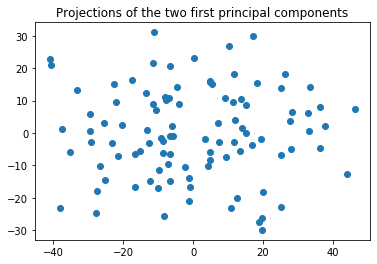

In [11]:
pca = PCA(n_components=4)
x_pca = pca.fit_transform(tab)

plt.scatter(x_pca[:,0],x_pca[:,1])
plt.title('Projections of the two first principal components')
plt.show()

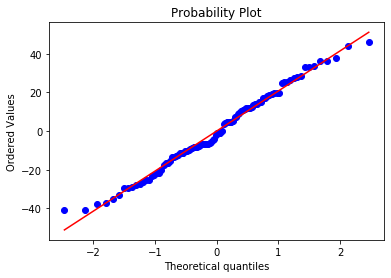

In [12]:
# Analyze the statistical distribution
import pylab
import scipy.stats as stats
data=x_pca[:,0]
stats.probplot(data, dist="norm", plot=pylab) 
pylab.show()

In [13]:
# Shapiro Test, test if the empirical distributions of the 4 principal components are gaussian where ‘x_pca’ is the array containing the principal components values
from scipy.stats import shapiro 
data=x_pca[:,0]; stat, p = shapiro(data) 
print('stat=%.3f, p=%.3f' % (stat, p)) 

if p > 0.05:
    print("Data follows Normal Distribution") 
else:
    print("Data does not follow Normal Distribution")

stat=0.986, p=0.352
Data follows Normal Distribution


### Diagnosis using the projected coefficients

In [14]:
import math 
from scipy.stats import chi2

def Prob_Zk(alpha=0.01,coefficients=x_pca):
    Y = []
    k = coefficients.shape[1]

    for i in range(k):
        sigma_i = math.sqrt(coefficients[:,i].var())
        y_i = coefficients[:,i]/sigma_i
        Y.append(y_i)

    return chi2.cdf(sum(Y), df=k-1)

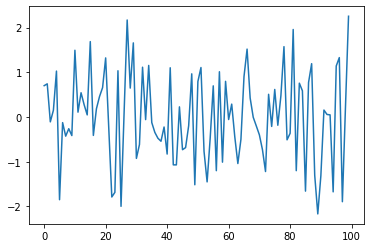

In [15]:
plt.plot(x_pca[:,1]/math.sqrt(np.var(x_pca[:,1])))
plt.show()